In [1]:
!pip install yfinance prophet

In [2]:
import numpy as np
import pandas as pd

In [21]:
from plotly.graph_objs import Figure, Candlestick

In [3]:
import yfinance as yf

In [4]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

In [5]:
import plotly.graph_objs as go

In [72]:
data = yf.download(tickers='BTC-USD', start='2020-01-01', end='2023-11-06', interval = '1d')

[*********************100%%**********************]  1 of 1 completed


In [73]:
data.reset_index(inplace=True)

In [48]:
data['Date'] = pd.to_datetime(data['Date'])

In [49]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


In [50]:
fig = go.Figure()

In [52]:
fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Stocks Data'))

In [53]:
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [54]:
df.rename (columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [55]:
df.head()

,ds,y
0,2020-01-01,7200.174316
1,2020-01-02,6985.470215
2,2020-01-03,7344.884277
3,2020-01-04,7410.656738
4,2020-01-05,7411.317383


In [56]:
df.info

<bound method DataFrame.info of              ds             y
0    2020-01-01   7200.174316
1    2020-01-02   6985.470215
2    2020-01-03   7344.884277
3    2020-01-04   7410.656738
4    2020-01-05   7411.317383
...         ...           ...
1400 2023-11-01  35437.253906
1401 2023-11-02  34938.242188
1402 2023-11-03  34732.324219
1403 2023-11-04  35082.195312
1404 2023-11-05  35049.355469

[1405 rows x 2 columns]>

In [57]:
df_train = df[df['ds']<='2023-09-30']
df_test = df[df['ds']>'2023-09-30']


print('The training dataset has', len(df_train), 'records, ranging from', df_train['ds'].min(), 'to', df_train['ds'].max())
print('The testing dataset has', len(df_test), 'records, ranging from', df_test['ds'].min(), 'to', df_test['ds'].max())

The training dataset has 1369 records, ranging from 2020-01-01 00:00:00 to 2023-09-30 00:00:00
The testing dataset has 36 records, ranging from 2023-10-01 00:00:00 to 2023-11-05 00:00:00


In [58]:
m = Prophet(interval_width=0.95, n_changepoints=7)


m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjvt1d4nt/xk4rrlpm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjvt1d4nt/mp9_6sjf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55355', 'data', 'file=/tmp/tmpjvt1d4nt/xk4rrlpm.json', 'init=/tmp/tmpjvt1d4nt/mp9_6sjf.json', 'output', 'file=/tmp/tmpjvt1d4nt/prophet_modelktb076qa/prophet_model-20240320083052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
08:30:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during 

In [59]:
future = m.make_future_dataframe(periods=31)


forecast = m.predict(future)


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1395,2023-10-27,43250.484366,34238.897646,51610.238407
1396,2023-10-28,43422.874930,34156.511778,53127.310992
1397,2023-10-29,43592.938986,34059.502386,52612.691305
1398,2023-10-30,43707.260025,33803.622345,53029.048060
1399,2023-10-31,43826.060115,35405.408614,53995.832843


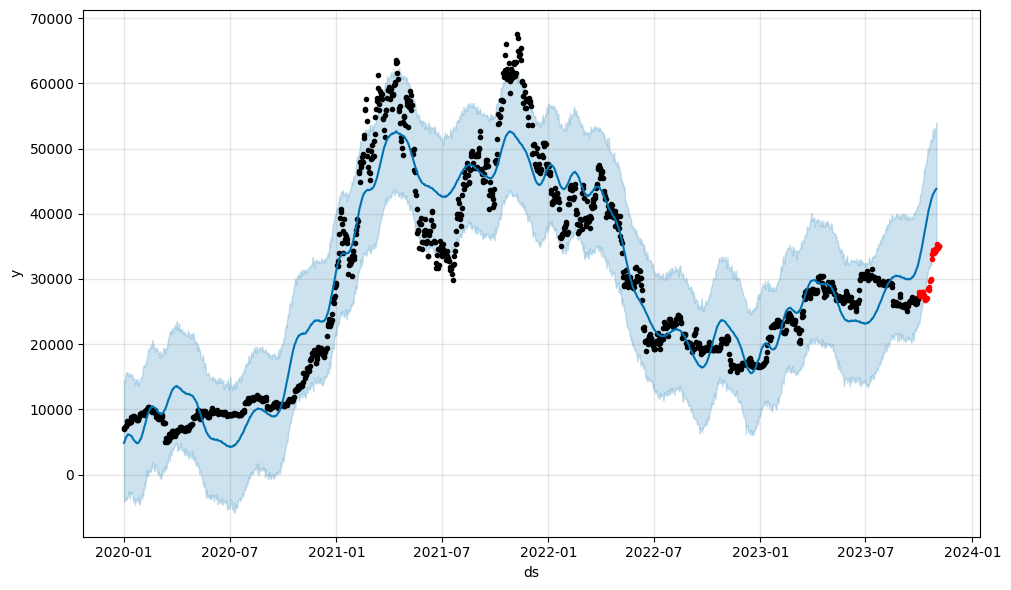

In [60]:
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')

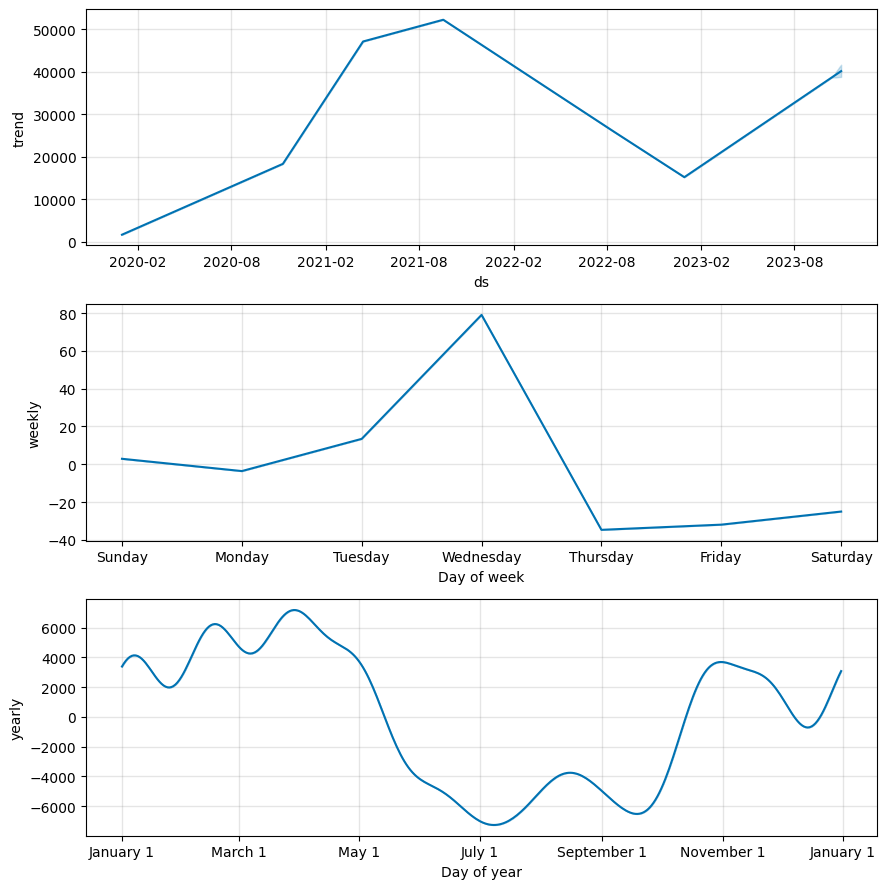

In [61]:
m.plot_components(forecast);

In [62]:
print(f'There are {len(m.changepoints)} change points. \nThe change points dates are \n{df.loc[df["ds"].isin(m.changepoints)]}')

There are 7 change points. 
The change points dates are 
             ds             y
156  2020-06-05   9665.533203
313  2020-11-09  15332.315430
469  2021-04-14  63109.695312
625  2021-09-17  47267.519531
781  2022-02-20  38431.378906
938  2022-07-27  22930.548828
1094 2022-12-30  16602.585938


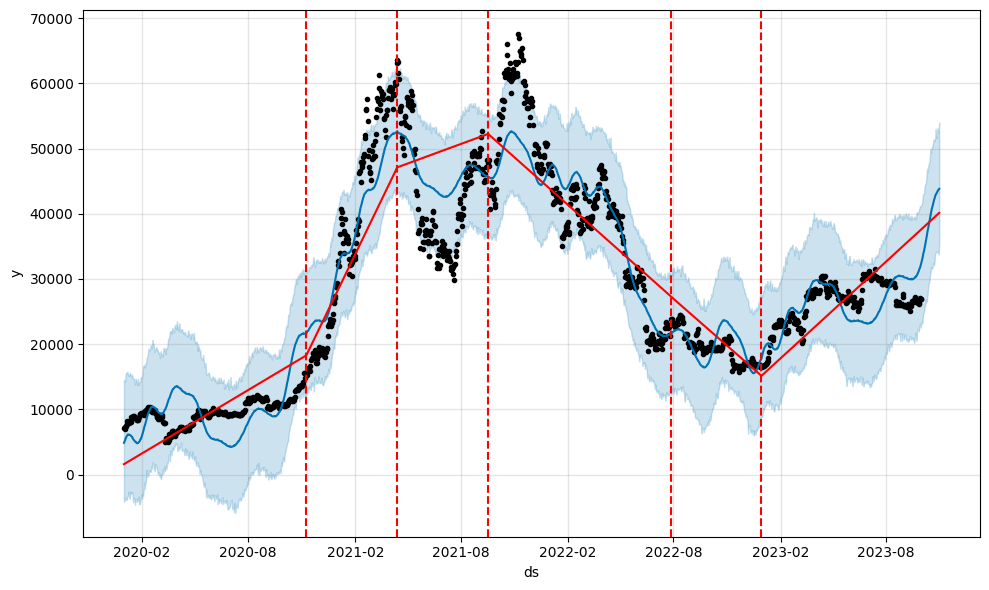

In [63]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [64]:
df_cv = cross_validation(m, initial='500 days', period='60 days', horizon = '30 days', parallel="processes")
df_cv.head()

INFO:prophet:Making 14 forecasts with cutoffs between 2021-07-12 00:00:00 and 2023-08-31 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7afaadc30fd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjvt1d4nt/bdukzgs1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjvt1d4nt/_ajj5oir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjvt1d4nt/1gvb5dsr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjvt1d4nt/7lv594yv.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48206', 'data', 'file=/tmp/tmpjvt1d4nt/_ajj5oir.json', 'init=/tmp/tmpjvt1d4nt/1gvb5dsr.json', 'output', 'file=/tmp/tmpjvt1d4nt/prophet_modelg4n4ylym/prophet_model-20240320083520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:CmdStan args

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-07-13,29181.632972,24394.157955,33869.620687,32702.025391,2021-07-12
1,2021-07-14,28863.165898,24199.248134,33516.372576,32822.347656,2021-07-12
2,2021-07-15,28490.759637,23921.814023,33374.945834,31780.730469,2021-07-12
3,2021-07-16,28129.778678,23417.399219,32916.374774,31421.539062,2021-07-12
4,2021-07-17,27767.393331,22739.388130,32423.924172,31533.068359,2021-07-12


In [65]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,4.334595e+07,6583.763906,3885.455069,0.119818,0.070780,0.112325,0.928571
1,4 days,4.375042e+07,6614.409759,4004.144369,0.124851,0.087294,0.118196,0.928571
2,5 days,4.642308e+07,6813.448171,4275.178022,0.137080,0.089717,0.130341,0.880952
3,6 days,5.035302e+07,7095.986231,4744.473925,0.152961,0.118934,0.147101,0.857143
4,7 days,5.563558e+07,7458.926327,5254.768481,0.167623,0.134716,0.162720,0.785714


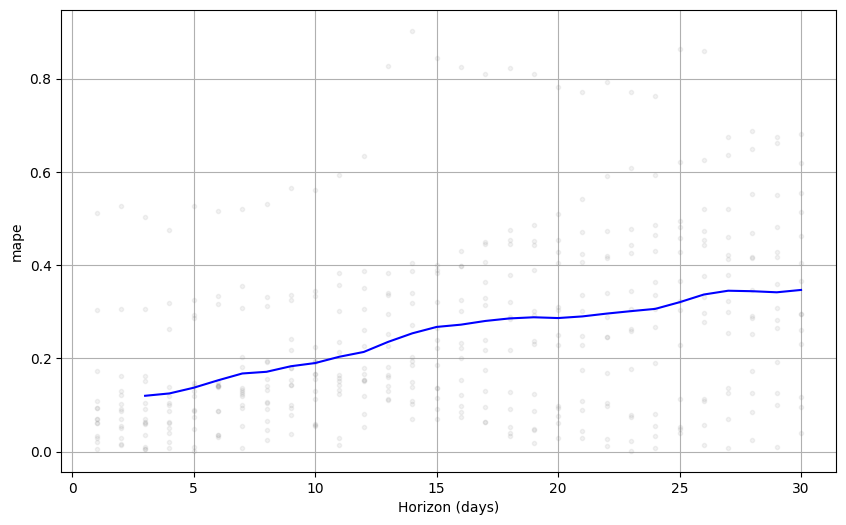

In [66]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [67]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [68]:
r2_score(df_cv.y, df_cv.yhat)

0.05817018887423209

In [69]:
mean_squared_error(df_cv.y, df_cv.yhat)

126040270.16315524

In [70]:
mean_absolute_error(df_cv.y, df_cv.yhat)

8285.303602837837

In [1]:
model.save(model.h5)

NameError: name 'model' is not defined

In [2]:
m.save(model.h5)

NameError: name 'm' is not defined